# Downloading SAMOS data from MarineFlux ERDDAP server

In [91]:
from erddapy import ERDDAP
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy.ma as ma

## Create the ERDDAP request

In [92]:
extent = [280.0, 290.0, 30.0, 40.0] # [lon-, lon+, lat-, lat+]
flux_algorithms = ["S88", "B12", "C35"]
erddap_samos = dict()

for algo in flux_algorithms:
  erddap_samos[algo] = ERDDAP(
    server="http://erddap-samos.coaps.fsu.edu/erddap",
    protocol="tabledap",
  )

  erddap_samos[algo].dataset_id = f"SAMOS_Fluxes_{algo}"
  erddap_samos[algo].constraints = {
      "time>=": "2021-01-01T00:00:00Z",
      "time<=": "2022-01-01T00:00:00Z",
      "longitude>=": extent[0],
      "longitude<=": extent[1],
      "latitude>=": extent[2],
      "latitude<=": extent[3],
  }
  erddap_samos[algo].variables = [
      "hfls",
      "hfss",
      "tau",
  ]

### URLs for ERDDAP request can be retrieved

In [93]:
for algo in flux_algorithms:
    erddap_samos[algo].response = "csv"
    print(f'Download CSV: {erddap_samos[algo].get_download_url()}')

    erddap_samos[algo].response = "html"
    print(f'View download form on ERDDAP server: {erddap_samos[algo].get_download_url()}')

Download CSV: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_S88.csv?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0
View download form on ERDDAP server: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_S88.html?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0
Download CSV: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_B12.csv?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0
View download form on ERDDAP server: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_B12.html?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=280.0&longitude<=290.0&latitude>=30.0&latitude<=40.0
Download CSV: http://erddap-samos.coaps.fsu.edu/erddap/tabledap/SAMOS_Fluxes_C35.csv?hfls,hfss,tau&time>=1609459200.0&time<=1640995200.0&longitude>=

## Request data as pandas DataFrame

In [94]:
df = dict()

for algo in flux_algorithms:
    df[algo] = erddap_samos[algo].to_pandas()

    print(df[algo])

        hfls (watts meter-2)  hfss (watts meter-2)  tau (newton meter-2)
0                        NaN                   NaN                   NaN
1                        NaN                   NaN                   NaN
2                        NaN                   NaN                   NaN
3                        NaN                   NaN                   NaN
4                        NaN                   NaN                   NaN
...                      ...                   ...                   ...
236488            160.313097             20.650944              0.064004
236489            151.599631             19.377516              0.058034
236490            158.456686             20.527104              0.059056
236491            158.751739             20.543149              0.065373
236492            155.547741             19.649620              0.061390

[236493 rows x 3 columns]
        hfls (watts meter-2)  hfss (watts meter-2)  tau (newton meter-2)
0                       

## Request data as xarray Dataset

In [95]:
ds = dict()

for algo in flux_algorithms:
    ds[algo] = erddap_samos[algo].to_xarray()

    print(ds[algo])

<xarray.Dataset>
Dimensions:    (row: 236493)
Coordinates:
    longitude  (row) float32 ...
    latitude   (row) float32 ...
    time       (row) datetime64[ns] ...
Dimensions without coordinates: row
Data variables:
    hfls       (row) float64 ...
    hfss       (row) float64 ...
    tau        (row) float64 ...
Attributes: (12/61)
    cdm_data_type:               Point
    comment:                     These data are the output of bulk flux calcu...
    contact_email:               samos@coaps.fsu.edu
    contact_info:                Center for Ocean-Atmospheric Prediction Stud...
    Conventions:                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                Center for Ocean-Atmospheric Prediction Stud...
    ...                          ...
    T_sensor_used:               T
    time_coverage_end:           2021-11-05T04:12:00Z
    time_coverage_start:         2021-02-19T06:07:00Z
    title:                       SAMOS MarineFlux S88
    TS_sensor_used:              TS
 

### Simple plot of latent heat flux

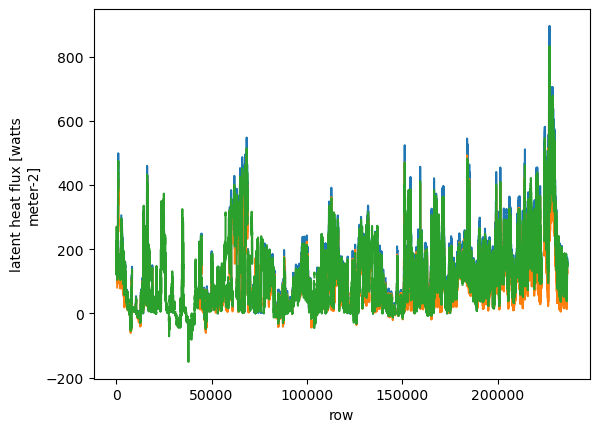

In [96]:
for algo in flux_algorithms:
    ds[algo]['hfls'].plot()

### Latent heat flux plotted as a function of time

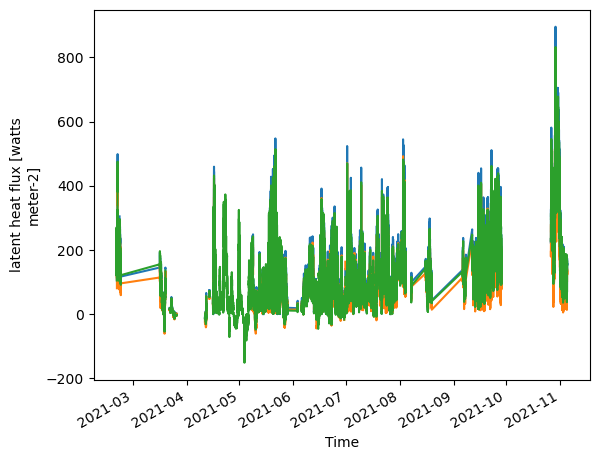

In [97]:
for algo in flux_algorithms:
    ds[algo]['hfls'].plot(x='time')

### Sensible and latent heat fluxes plotted on a map

In [98]:
def plot_shared_colorbar(dataset, vars, cmap='bwr', diverging=True, sort=False):
    height = 5
    figsize = (len(vars) * height, height)
    fig = plt.figure(figsize=figsize, layout='constrained')
    fig.suptitle(dataset.title)

    projection = ccrs.PlateCarree()

    ax_dict = fig.subplot_mosaic(
        [
            vars,
            ['cbar' for var in vars]
        ],
        height_ratios=[20, 1],
        per_subplot_kw={
            tuple(vars): {'projection': projection}
        }
    )

    vmax = -1
    for var in vars:
        ax_dict[var].set_extent(extent, crs=projection)
        ax_dict[var].stock_img()
        ax_dict[var].coastlines()
        ax_dict[var].set_title(f'{dataset[var].long_name} ({dataset[var].units})')

        vmax = max(vmax, ma.max(abs(ma.masked_invalid(ds[algo][var]))))

    if diverging:
        vmin = -vmax
    else:
        vmin = 0

    scatter = []
    for var in vars:
        # sorting the DataArray before plotting makes the higher values show up on top. this is useful for seeing where the high values are, but obscures the negative values.
        if sort:
            da = dataset[var].sortby(dataset[var])
        else:
            da = dataset[var]
        scatter.append(ax_dict[var].scatter(x=da['longitude'], y=da['latitude'], c=da, cmap=cmap, vmin=vmin, vmax=vmax))

    cbar = plt.colorbar(scatter[0], cax=ax_dict['cbar'], orientation='horizontal')

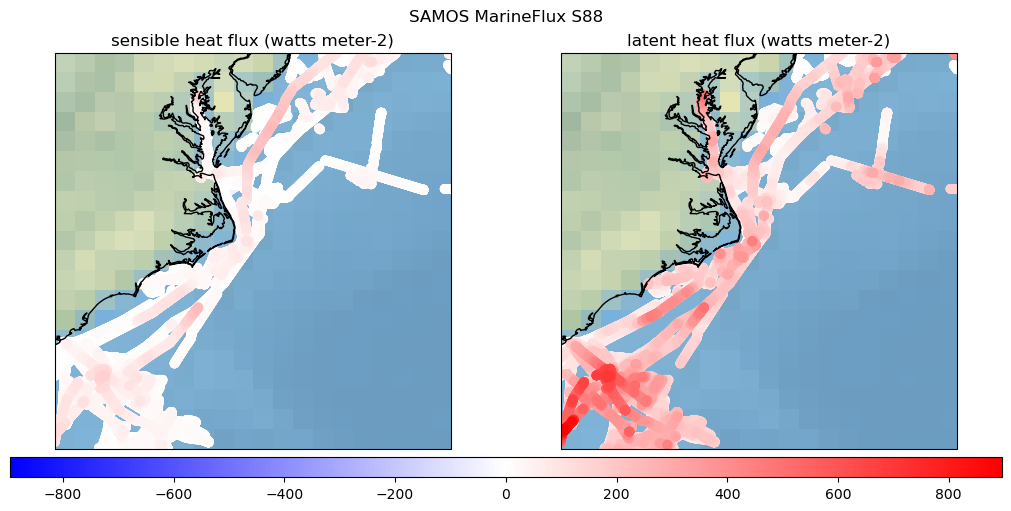

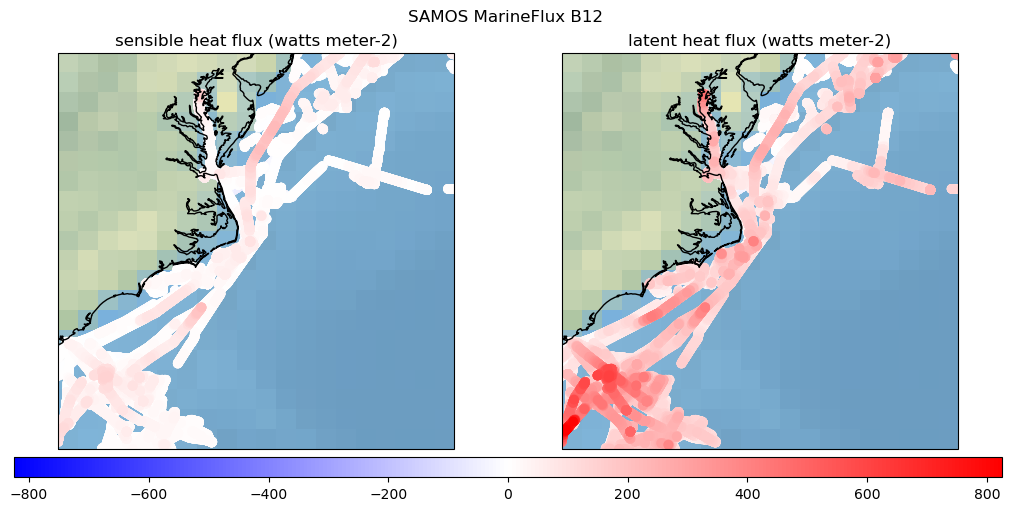

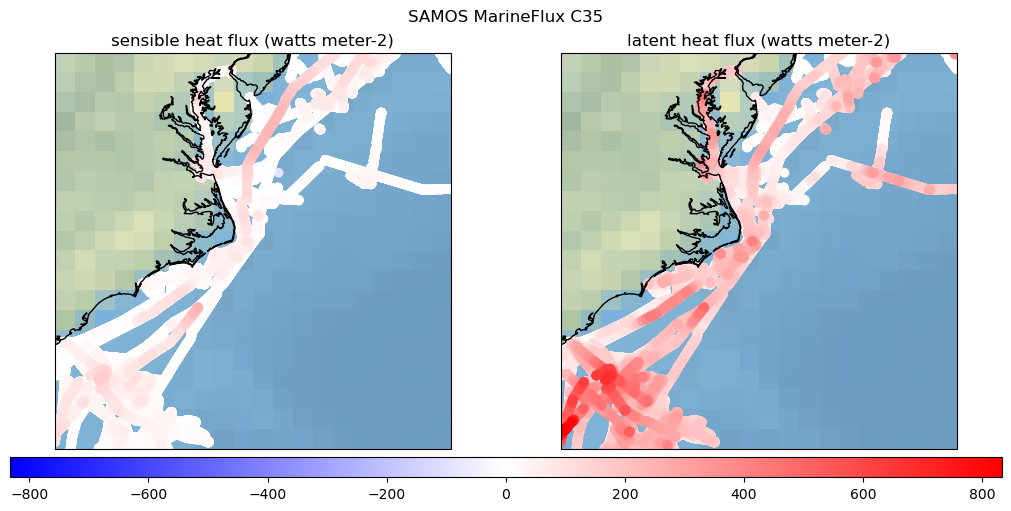

In [99]:
for algo in flux_algorithms:
    plot_shared_colorbar(ds[algo], ['hfss', 'hfls'], sort=True)

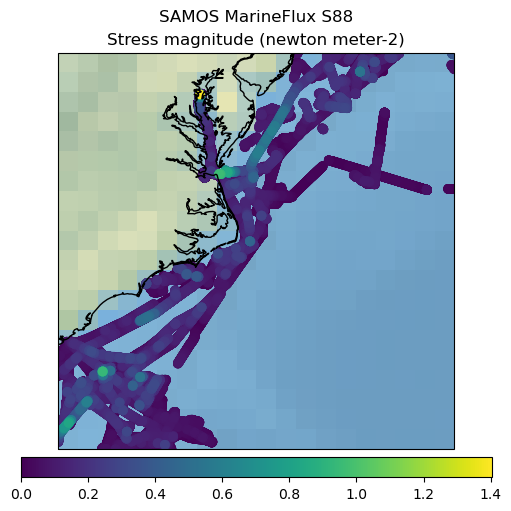

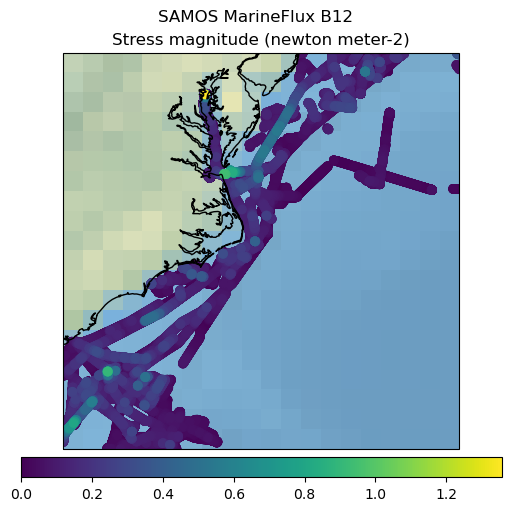

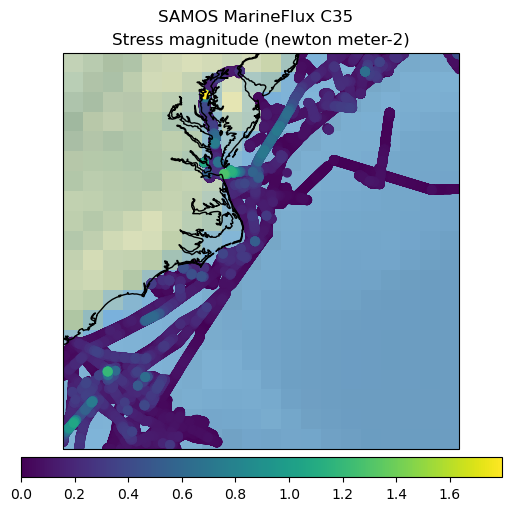

In [100]:
for algo in flux_algorithms:
    plot_shared_colorbar(ds[algo], ['tau'], cmap='viridis', diverging=False, sort=True)

In [101]:
def plot_dataset_comparison(datasets, var, sort=False, cmap='bwr', diverging=True):
    keys = list(datasets.keys())
    height = 5
    figsize = (len(datasets) * height, height)
    fig = plt.figure(figsize=figsize, layout='constrained')
    fig.suptitle(f'{ds[keys[0]][var].long_name} ({ds[keys[0]][var].units})')

    projection = ccrs.PlateCarree()

    ax_dict = fig.subplot_mosaic(
        [
            [algo for algo in keys],
            ['cbar' for algo in keys]
        ],
        height_ratios=[20, 1],
        per_subplot_kw={
            tuple(algo for algo in keys): {'projection': projection}
        }
    )

    vmax = -1
    for algo in keys:
            
        ax_dict[algo].set_extent(extent, crs=projection)
        ax_dict[algo].stock_img()
        ax_dict[algo].coastlines()
        ax_dict[algo].set_title(f'{datasets[algo][var].long_name} ({datasets[algo][var].units})')

        vmax = max(vmax, ma.max(abs(ma.masked_invalid(datasets[algo][var]))))

        ax_dict[algo].set_title(datasets[algo].title)

    if diverging:
        vmin = -vmax
    else:
        vmin = 0

    scatter = []
    for algo in keys:
        # sorting the DataArray before plotting makes the higher values show up on top. this is useful for seeing where the high values are, but obscures the negative values.
        if sort:
            da = datasets[algo][var].sortby(datasets[algo][var])
        else:
            da = datasets[algo][var]
        scatter.append(ax_dict[algo].scatter(x=da['longitude'], y=da['latitude'], c=da, cmap=cmap, vmin=vmin, vmax=vmax))

    cbar = plt.colorbar(scatter[0], cax=ax_dict['cbar'], orientation='horizontal')

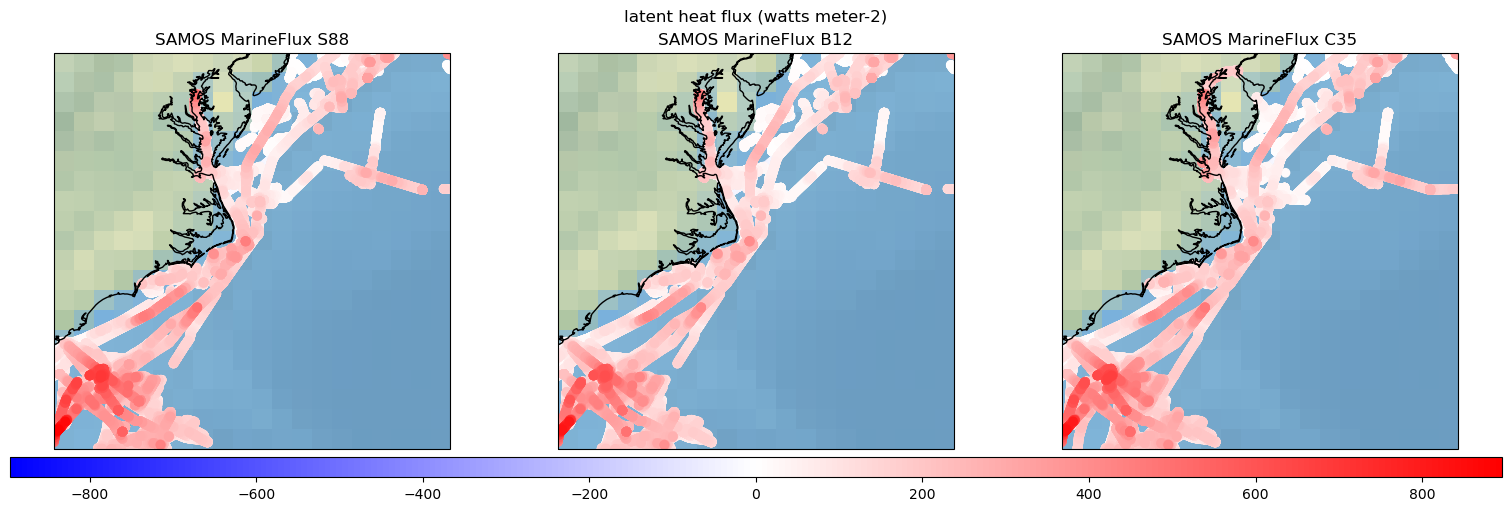

In [102]:
plot_dataset_comparison(ds, 'hfls', sort=True)

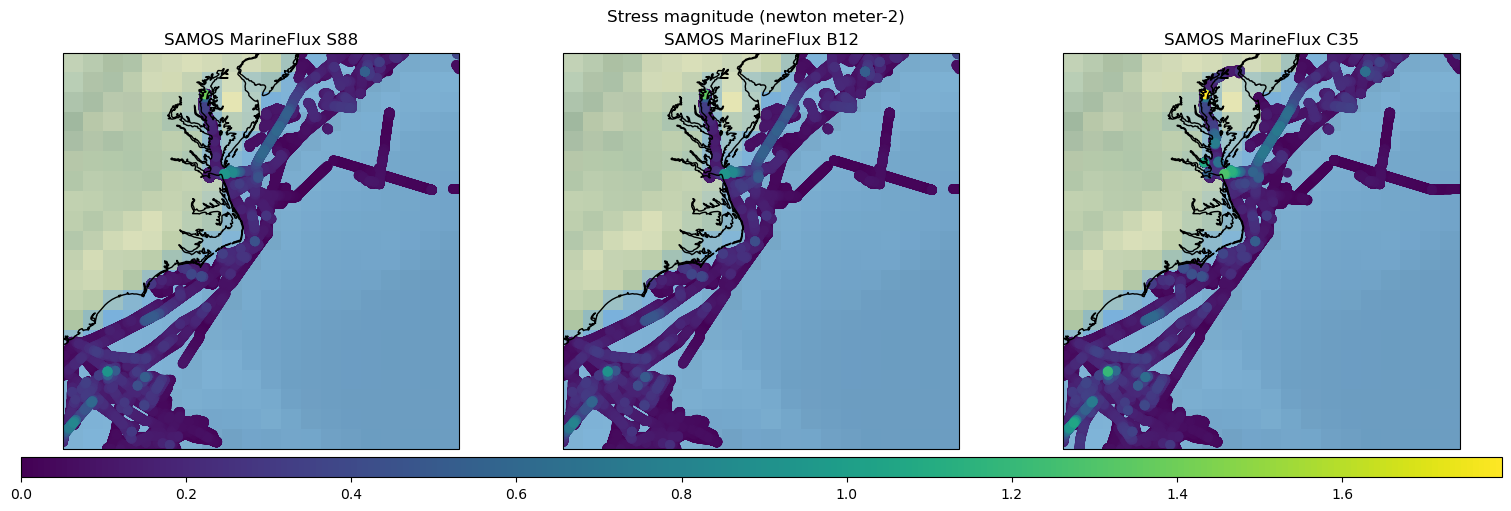

In [103]:
plot_dataset_comparison(ds, 'tau', cmap='viridis', diverging=False, sort=True)